# Modelo simples de segmentação

Em segmentação, queremos encontrar **para cada pixel da imagem**, a classe a qual ele pertence. Para isso, podemos usar uma rede totalmente convolucional, do inglês *fully convolutional network*.

In [1]:
from pathlib import Path

import dataset
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn

root = Path("../data/oxford_pets")

ds_train, ds_valid, class_weights = dataset.get_dataset(root)

In [2]:
class SegModel(nn.Module):
    """Modelo FCN (fully convolutional network) simples."""
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 2, kernel_size=3, padding=1)  # Camada de classificação
        )

    def forward(self, x):
        return self.layers(x)

# Imagem aleatória de exemplo
x = ds_train[0][0]
x = x.unsqueeze(0)
model = SegModel()
with torch.no_grad():
    y = model(x)[0]
y.shape

torch.Size([2, 384, 384])

O modelo acima recebe como entrada uma imagem e gera como resultado uma imagem de mesmo tamanho possuindo 2 canais. 

Em tarefas de segmentação, o valor `y[c,row,col]` irá representar os scores do pixel `(row,col)` de pertencer à classe `c`

In [3]:
#scores do pixel (10,34):
scores_pixel = y[:,10,34]
print(scores_pixel)

tensor([-0.3584, -0.0558])


Se quisermos encontrar as probabilidades de cada pixel pertencer a uma classe 

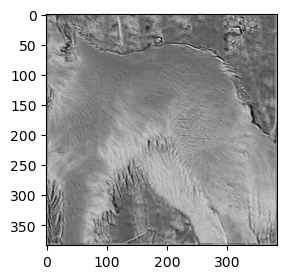

In [4]:
probs = F.softmax(y, dim=0)
plt.imshow(probs[0], "gray")

O modelo ainda não foi treinado, então ele dá um resultado ruim. Mas temos outro problema, para classificar cada pixel, o modelo considera apenas uma pequena região no entorno do pixel. 

A região da imagem utilizada pelo modelo para classificar cada pixel é chamada de **campo receptivo**. O nosso modelo possui um campo receptivo de tamanho 9x9 (veja a seção sobre decodificadores das notas de aula). Portanto, apenas uma região de tamanho 9x9 será utilizada para definir se um pixel pertence a um cachorro ou ao fundo da imagem. Está claro que em muitas situações será necessário informações mais globais para classificar os pixeis. Por exemplo, como esse modelo irá diferenciar o pelo de um cachorro branco e a parede branca de uma casa? 

### Codificadores

Para extrair informações globais, precisamos extrair atributos da imagem em múltiplas escalas espaciais. Podemos fazer isso utilizando um modelo pré-treinado para processar a imagem.

É possível extrair os atributos de qualquer camada de uma rede neural utilizando hooks (um tipo de callback), mas para simplificar, iremos extrair os atributos especificamente de uma rede ResNet do Pytorch 

In [5]:
from torchvision import models

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.eval();

No código-fonte do Pytorch, o método .forward() está implementado da seguinte forma:

```python
def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
```

Vamos implementar uma função que extrai ativações intermediárias da ResNet

In [6]:
def get_features(model, x):
    
    features = []
    x = model.conv1(x)
    x = model.bn1(x)
    x = model.relu(x)
    features.append(x)
    x = model.maxpool(x)

    x = model.layer1(x)
    features.append(x)
    x = model.layer2(x)
    features.append(x)
    x = model.layer3(x)
    features.append(x)
    x = model.layer4(x)
    features.append(x)

    return features

x = ds_train[0][0]
x = x.unsqueeze(0)

with torch.no_grad():
    features = get_features(model, x)

# Tamanhos das ativações intermediárias
for feature in features:
    print(feature.shape)

torch.Size([1, 64, 192, 192])
torch.Size([1, 64, 96, 96])
torch.Size([1, 128, 48, 48])
torch.Size([1, 256, 24, 24])
torch.Size([1, 512, 12, 12])


As ativações intermediárias representam atributos extraídos das imagens em diferentes escalas. Por exemplo, features[0] possui 64 atributos extraídos para cada pixel em uma escala bem pequena, com campo receptivo da ordem de 10x10. Esses atributos caracterizam a textura do objeto ou a presença de bordas. features[-1] possui 512 atributos extraídos para cada pixel em uma escala muito grande, considerando a imagem toda. 

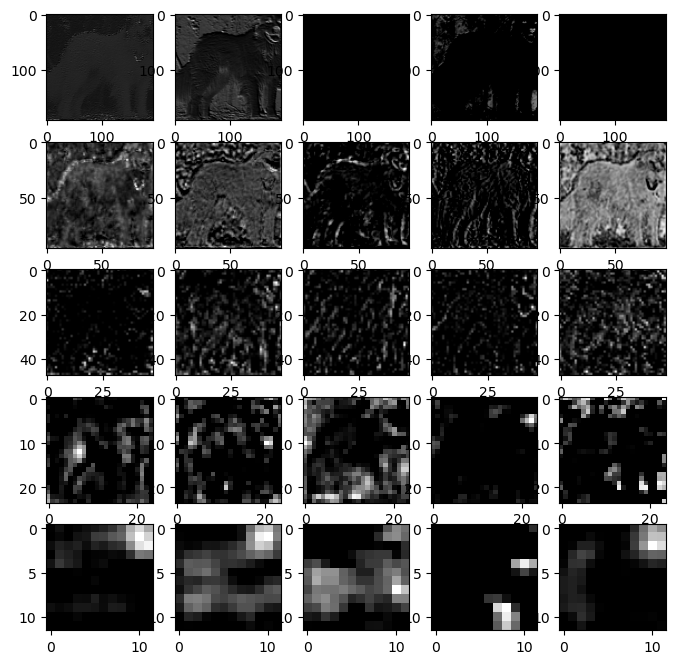

In [7]:
# Visualização dos 5 primeiros canais das ativações extraídas em cada escala
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for scale in range(5):
    for idx in range(5):
        axs[scale,idx].imshow(features[scale][0][idx], "gray")
        axs[scale,idx].imshow(features[scale][0][idx], "gray")
        axs[scale,idx].imshow(features[scale][0][idx], "gray")
        axs[scale,idx].imshow(features[scale][0][idx], "gray")
        axs[scale,idx].imshow(features[scale][0][idx], "gray")